In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.spatial.distance import cdist
from scipy.linalg import expm, logm, eig, eigh, inv, null_space
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import expm_multiply
from scipy.optimize import curve_fit
from functools import reduce
from scipy.linalg import schur

In [2]:
# Define single spin operators
Sx = (1/2)*np.array([[0, 1], [1, 0]], dtype=complex)
Sy = (1j/2)*np.array([[0, -1], [1, 0]], dtype=complex)
Sz = (1/2)*np.array([[1, 0], [0, -1]], dtype=complex)
Id = np.eye(2, dtype=complex)

In [3]:
#Definitions for building spin operators in multi-spin hilbert space
def operator_on_spin(op, target, N):
    ops = [Id] * N
    ops[target] = op
    return reduce(np.kron, ops)

def build_spin_operators(N):
    Ix, Iy, Iz = {}, {}, {}
    for n in range(N):
        Ix[n] = operator_on_spin(Sx, n, N)
        Iy[n] = operator_on_spin(Sy, n, N)
        Iz[n] = operator_on_spin(Sz, n, N)
    return Ix, Iy, Iz

def total_spin_operators(N, Ix, Iy, Iz):
    Ix_tot =np.zeros((2**N, 2**N), dtype = complex)
    Iy_tot =np.zeros((2**N, 2**N), dtype = complex)
    Iz_tot =np.zeros((2**N, 2**N), dtype = complex)
    for n in range(N):
        Ix_tot += Ix[n]
        Iy_tot += Iy[n]
        Iz_tot += Iz[n]
    return Ix_tot, Iy_tot, Iz_tot

2.530954360961914


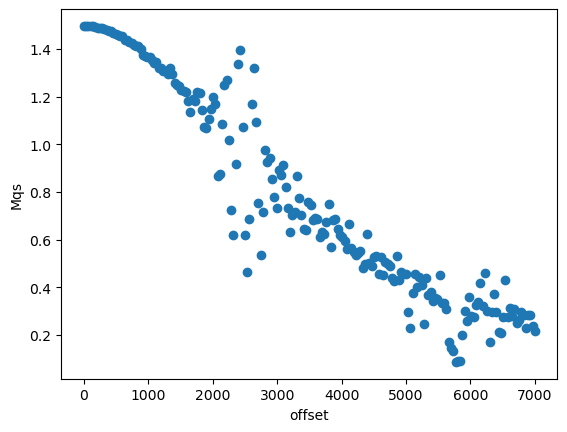

In [137]:
#Instead of Floquet eigenmode projection, this just applies U_RF 100 times (takes longer though)

import time

def calculate_Mqs(N, offset, seed):
    
    #Define experiment parameters and Hamiltonians
    w_rabi = 1/(4*38e-6)
    pulselength = 38e-6
    delay = 40e-6
    dt = 100e-9
    time = np.linspace(0, pulselength+delay, int((pulselength+delay)/dt))

    Ix, Iy, Iz = build_spin_operators(N)
    Ix_tot, Iy_tot, Iz_tot = total_spin_operators(N, Ix, Iy, Iz)

    if seed is not None:
        np.random.seed(seed)
    
    H_dd = np.zeros((2**N, 2**N), dtype=complex)
    for i in range(N):
        for j in range(i+1, N):
            d_ij = np.random.uniform(-1000,1000)
            H_ij = -(Ix[i] @ Ix[j]) - (Iy[i] @ Iy[j]) + 2*(Iz[i] @ Iz[j])
            H_dd += d_ij * H_ij

            
    H_pulse = 2*np.pi*w_rabi*Ix_tot + 2*np.pi*offset*Iz_tot
    H_delay = 2*np.pi*offset*Iz_tot
    
    
    #Calculate Floquet Hamiltonian exactly
    def H_total(t):
        if t < pulselength:
            return H_dd + H_pulse
        else:
            return H_dd + H_delay

    U_pulse = expm(-1j * (H_dd + H_pulse) * pulselength)
    U_delay = expm(-1j * (H_dd + H_delay) * delay)
    U = U_delay @ U_pulse

    H_eff = (1j / (pulselength + delay)) * logm(U)

#     p0 = np.random.dirichlet(np.ones(N))
# #     p0 = np.zeros(N)
# #     p0[0] = 1
#     rho_pol = sum(p0[i] * Ix[i] for i in range(N))
#     rho = (np.eye(2**N) + 1e-2 * rho_pol) / 2**N
    rho = Ix_tot / 2**N
    
    for _ in range(100):
        rho = U @ rho @ U.conj().T
        
    return np.trace(rho@Ix_tot).real


N = 6 #number of spins
n_offsets = 200
offset = np.linspace(0,7e3,n_offsets)
M_qs = np.zeros(n_offsets)

start_time = time.time()

for i in range(n_offsets):
    M_qs[i] = calculate_Mqs(N, offset[i], None)

end_time = time.time()
print(end_time-start_time)


fig = plt.figure()
plt.scatter(offset, M_qs)
plt.xlabel("offset")
plt.ylabel("Mqs")
plt.show()

1.242905855178833


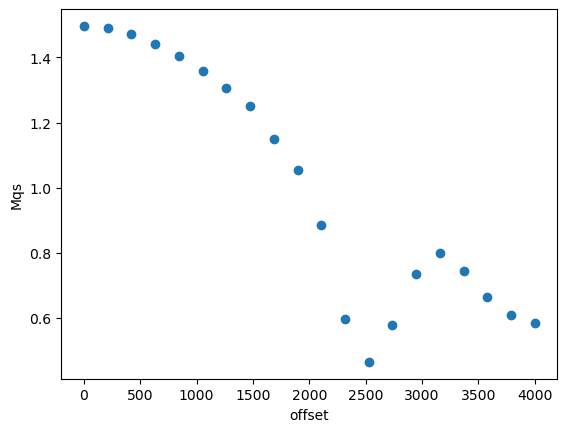

In [138]:
import time

def calculate_Mqs_average(N, offset, seeds):
    M = 0 
    for s in seeds:
        M += calculate_Mqs(N, offset, s)
    return M / len(seeds)

N = 6 #number of spins
seeds = range(5)
n_offsets = 20
offset = np.linspace(0, 4e3, n_offsets)
M_qs = np.zeros(n_offsets)

start_time = time.time()

for i in range(n_offsets):
    M_qs[i] = calculate_Mqs_average(N, offset[i], seeds)

end_time = time.time()
print(end_time-start_time)

    
fig = plt.figure()
plt.scatter(offset, M_qs)
plt.xlabel("offset")
plt.ylabel("Mqs")
plt.show()

In [75]:
#Definition for calculating rho_qs where d_ij is uniformly sampled from -1 to +1 kHz

def calculate_rho_qs(N, offset, seed, Ix, Iy, Iz, Ix_tot, Iy_tot, Iz_tot):
    
    #Define experiment parameters and Hamiltonians
    w_rabi = 1/(4*56e-6)
    pulselength = 56e-6
    delay = 36e-6

    if seed is not None:
        np.random.seed(seed)
    
    H_dd = np.zeros((2**N, 2**N), dtype=complex)
    for i in range(N):
        for j in range(i+1, N):
            d_ij = 100*np.random.uniform(-100,100)
            H_ij = -(Ix[i] @ Ix[j]) - (Iy[i] @ Iy[j]) + 2*(Iz[i] @ Iz[j])
            H_dd += d_ij * H_ij

            
    H_pulse = 2*np.pi*w_rabi*Ix_tot + 2*np.pi*offset*Iz_tot
    H_delay = 2*np.pi*offset*Iz_tot
    
    U_pulse = expm(-1j * (H_dd + H_pulse) * pulselength)
    U_delay = expm(-1j * (H_dd + H_delay) * delay)
    U = U_delay @ U_pulse

#     H_eff = (1j / (pulselength + delay)) * logm(U)
    
    rho0 = Ix_tot / 2**N
    
#     eigvals, eigvecs = eig(U)
#     U_dag = inv(eigvecs)

    T, Z = schur(U)  # U = Z T Z†, T is upper-triangular (nearly diagonal)

    rho_rot = Z.conj().T @ rho0 @ Z #rotate into Floquet eigenbasis

    rho_diag = np.diag(np.diag(rho_rot)) #Discard off-diagonals (RWA)

    rho_qs = Z @ rho_diag @ Z.conj().T #Rotate back to quasistationary rho
    
    return rho_qs


0.01631927490234375


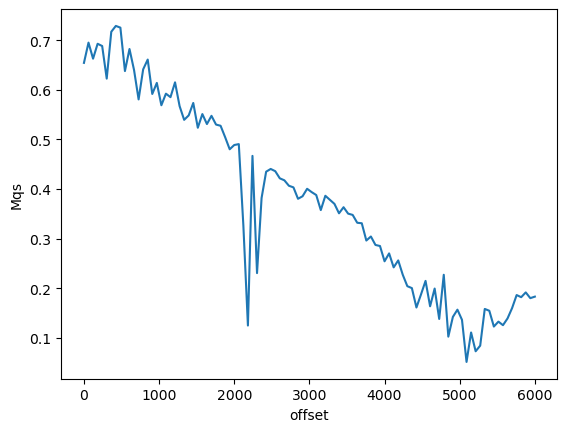

In [78]:
#This will calculate rho_qs using Floquet eigenmode projection method (and M_qs as a function of offset)

import time

N = 3 #number of spins

Ix, Iy, Iz = build_spin_operators(N)
Ix_tot, Iy_tot, Iz_tot = total_spin_operators(N, Ix, Iy, Iz)

n_offsets = 100
offset = np.linspace(0, 6e3, n_offsets)
M_qs = np.zeros(n_offsets)

start_time = time.time()

for i in range(n_offsets):
    rho_qs = calculate_rho_qs(N, offset[i], None, Ix, Iy, Iz, Ix_tot, Iy_tot, Iz_tot)
    M_qs[i] = np.trace(rho_qs @ Ix_tot).real

end_time = time.time()
print(end_time-start_time)


fig = plt.figure()
plt.plot(offset, M_qs)
plt.xlabel("offset")
plt.ylabel("Mqs")
plt.show()

32027.210196733475


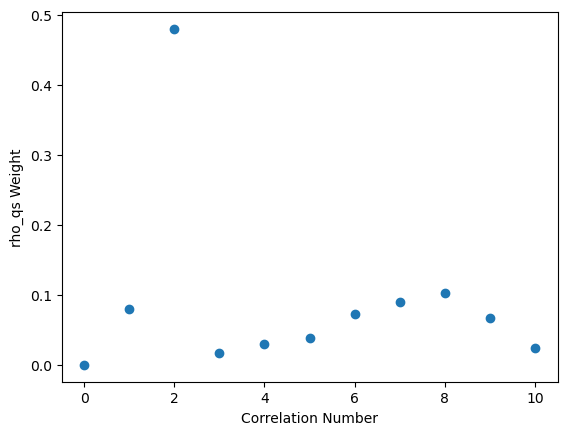

In [310]:
#For one offset value, this will compute the operator size distribution of rho_qs

single_qubit_ops = {
    'x': np.array([[0, 1], [1, 0]], dtype=np.complex64), 
    'y': np.array([[0, -1j], [1j, 0]], dtype=np.complex64), 
    'z': np.array([[1, 0], [0, -1]], dtype=np.complex64),
    'i': np.eye(2, dtype=complex)
}


from itertools import product

def generate_spin_operator_terms(N, max_weight):
    labels = ['x', 'y', 'z', 'i']
    operators = []
    weights = []

    for label_tuple in product(labels, repeat=N):
        weight = sum(1 for l in label_tuple if l != 'i')
        if weight > max_weight:
            continue
        op_list = [single_qubit_ops[l] for l in label_tuple]
        full_op = op_list[0]
        for op in op_list[1:]:
            full_op = np.kron(full_op, op)
        full_op = full_op.astype(np.complex64) 
        yield full_op, weight

    return operators, weights


def compute_size_distribution_lazy(N, max_weight, rho, operators, weights):
    from collections import defaultdict
    size_dist = defaultdict(float)

    for op, w in generate_spin_operator_terms(N, max_weight):
        coeff = np.trace(op.conj().T @ rho) / 2**N
        size_dist[w] += np.abs(coeff)**2

    return size_dist

N = 8

Ix, Iy, Iz = build_spin_operators(N)
Ix_tot, Iy_tot, Iz_tot = total_spin_operators(N, Ix, Iy, Iz)

start_time = time.time()


rho_qs = calculate_rho_qs(N, 5800, 1, Ix, Iy, Iz, Ix_tot, Iy_tot, Iz_tot)
rho_qs = rho_qs.astype(np.complex64)
size_dist = compute_size_distribution_lazy(N, N, rho_qs, operators, weights)

weights = sorted(size_dist.keys())
contributions = [size_dist[w] for w in weights]
total = sum(contributions)
contributions = [c / total for c in contributions]
    
    
end_time = time.time()
print(end_time-start_time)    
    
    
fig = plt.figure()
plt.scatter(weights, contributions)
plt.xlabel("Correlation Number")
plt.ylabel("rho_qs Weight")
plt.show()

In [90]:
#Definition for calculting rho_qs where r_ij is sampled from an exponential distribution with mean lambda

def calculate_rho_qs(N, lamb, offset, seed, Ix, Iy, Iz, Ix_tot, Iy_tot, Iz_tot):
    
    #Define experiment parameters and Hamiltonians
    w_rabi = 1/(4*56e-6)
    pulselength = 56e-6
    delay = 36e-6
    
#     lamb = 5e-9
    mu_0 = 1.256e-6 #NA^-2
    hbar = 1.055e-34 #Js
    gamma_C = 10.7084e6 #Hz/T
    A = (mu_0*hbar*gamma_C**2) / 2

    if seed is not None:
        np.random.seed(seed)
    
    H_dd = np.zeros((2**N, 2**N), dtype=complex)
    for i in range(N):
        for j in range(i+1, N):
            r_ij = np.clip(np.random.exponential(scale = lamb), 1.5e-10, None)
            d_ij = np.random.choice([-1,1]) * (A / r_ij**3)
            H_ij = -(Ix[i] @ Ix[j]) - (Iy[i] @ Iy[j]) + 2*(Iz[i] @ Iz[j])
            H_dd += d_ij * H_ij

            
    H_pulse = 2*np.pi*w_rabi*Ix_tot + 2*np.pi*offset*Iz_tot
    H_delay = 2*np.pi*offset*Iz_tot

    U_pulse = expm(-1j * (H_dd + H_pulse) * pulselength)
    U_delay = expm(-1j * (H_dd + H_delay) * delay)
    U = U_delay @ U_pulse

#     H_eff = (1j / (pulselength + delay)) * logm(U)
    
    rho0 = Ix_tot / 2**N
    
    #Calculate rho_qs
#     eigvals, eigvecs = eig(U)
#     U_dag = inv(eigvecs)

    T, Z = schur(U)  # U = Z T Z†, T is upper-triangular (nearly diagonal)

    rho_rot = Z.conj().T @ rho0 @ Z #rotate into Floquet eigenbasis

    rho_diag = np.diag(np.diag(rho_rot)) #Discard off-diagonals (RWA)

    rho_qs = Z @ rho_diag @ Z.conj().T #Rotate back to quasistationary rho
    
    return rho_qs

0.7328903675079346


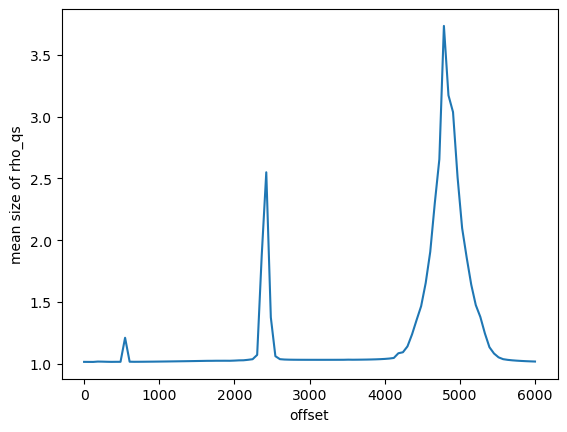

In [91]:
#Calculate the mean Pauli weight of rho_qs as a function of offset

import time

pauli_ops = {
    'x': np.array([[0, 1], [1, 0]], dtype=complex), 
    'y': np.array([[0, -1j], [1j, 0]], dtype=complex), 
    'z': np.array([[1, 0], [0, -1]], dtype=complex),
    'i': np.eye(2, dtype=complex)
}

from functools import reduce

def kron_n(ops):
    return reduce(np.kron, ops)

def construct_single_pauli(P, i, N):
    op_list = [pauli_ops['i']] * N
    op_list[i] = pauli_ops[P]
    return kron_n(op_list)

def size_superoperator(rho, N):
    
    S_O = np.zeros_like(rho, dtype=complex)

    for i in range(N):
        for P in ['x', 'y', 'z']:
            P_i = construct_single_pauli(P, i, N)
            S_O += (-1/4) * (P_i @ rho @ P_i.conj().T - rho)
            
    return S_O

def mean_size(rho, N):
    S_O = size_superoperator(rho, N)
    norm = np.trace(rho.conj().T @ rho).real / 2**N
    size = np.trace(rho.conj().T @ S_O).real / 2**N
    return size / norm


N = 6 #number of spins

lamb = 5e-10 #Mean distance between spins

Ix, Iy, Iz = build_spin_operators(N)
Ix_tot, Iy_tot, Iz_tot = total_spin_operators(N, Ix, Iy, Iz)

n_offsets = 100
offset = np.linspace(0, 6e3, n_offsets)
size = np.zeros(n_offsets)

start_time = time.time()

for i in range(n_offsets):
    rho_qs = calculate_rho_qs(N, lamb, offset[i], 1, Ix, Iy, Iz, Ix_tot, Iy_tot, Iz_tot)
    size[i] = mean_size(rho_qs, N)

end_time = time.time()
print(end_time-start_time)


fig = plt.figure()
plt.plot(offset, size)
plt.xlabel("offset")
plt.ylabel("mean size of rho_qs")
plt.show()

4345.531938314438


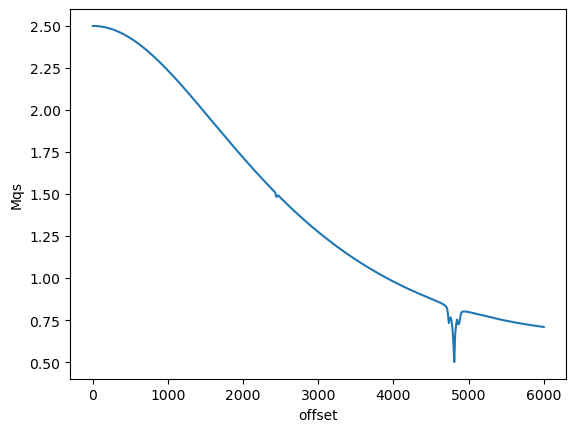

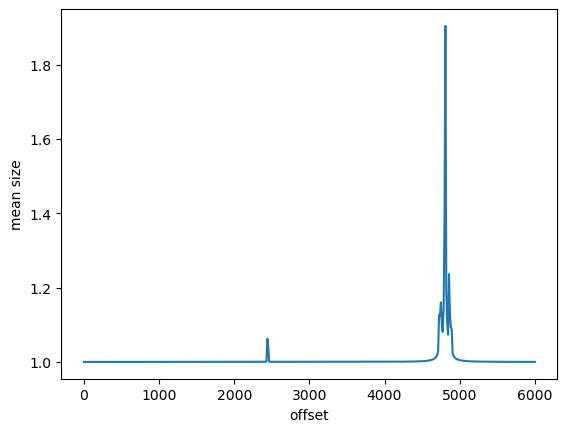

In [452]:
#FUll MASTER CODE

#Calculate both Mqs and mean Pauli weight as a fucntion of offset

# Define single spin operators
Sx = (1/2)*np.array([[0, 1], [1, 0]], dtype=complex)
Sy = (1j/2)*np.array([[0, -1], [1, 0]], dtype=complex)
Sz = (1/2)*np.array([[1, 0], [0, -1]], dtype=complex)
Id = np.eye(2, dtype=complex)

def operator_on_spin(op, target, N):
    ops = [Id] * N
    ops[target] = op
    return reduce(np.kron, ops)

def build_spin_operators(N):
    Ix, Iy, Iz = {}, {}, {}
    for n in range(N):
        Ix[n] = operator_on_spin(Sx, n, N)
        Iy[n] = operator_on_spin(Sy, n, N)
        Iz[n] = operator_on_spin(Sz, n, N)
    return Ix, Iy, Iz

def total_spin_operators(N, Ix, Iy, Iz):
    Ix_tot =np.zeros((2**N, 2**N), dtype = complex)
    Iy_tot =np.zeros((2**N, 2**N), dtype = complex)
    Iz_tot =np.zeros((2**N, 2**N), dtype = complex)
    for n in range(N):
        Ix_tot += Ix[n]
        Iy_tot += Iy[n]
        Iz_tot += Iz[n]
    return Ix_tot, Iy_tot, Iz_tot

def calculate_rho_qs(N, lamb, offset, seed, Ix, Iy, Iz, Ix_tot, Iy_tot, Iz_tot):
    
    #Define experiment parameters and Hamiltonians
    w_rabi = 1/(4*56e-6)
    pulselength = 56e-6
    delay = 36e-6
    
#     lamb = 5e-9
    mu_0 = 1.256e-6 #NA^-2
    hbar = 1.055e-34 #Js
    gamma_C = 10.7084e6 #Hz/T
    A = (mu_0*hbar*gamma_C**2) / 2

    if seed is not None:
        np.random.seed(seed)
    
    H_dd = np.zeros((2**N, 2**N), dtype=complex)
    for i in range(N):
        for j in range(i+1, N):
            r_ij = np.clip(np.random.exponential(scale = lamb), 1.5e-10, None)
            d_ij = np.random.choice([-1,1]) * (A / r_ij**3)
            H_ij = -(Ix[i] @ Ix[j]) - (Iy[i] @ Iy[j]) + 2*(Iz[i] @ Iz[j])
            H_dd += d_ij * H_ij

            
    H_pulse = 2*np.pi*w_rabi*Ix_tot + 2*np.pi*offset*Iz_tot
    H_delay = 2*np.pi*offset*Iz_tot

    U_pulse = expm(-1j * (H_dd + H_pulse) * pulselength)
    U_delay = expm(-1j * (H_dd + H_delay) * delay)
    U = U_delay @ U_pulse

#     H_eff = (1j / (pulselength + delay)) * logm(U)
    
    rho0 = Ix_tot / 2**N
    
    #Calculate rho_qs
#     eigvals, eigvecs = eig(U)
#     U_dag = inv(eigvecs)

    T, Z = schur(U)  # U = Z T Z†, T is upper-triangular (nearly diagonal)

    rho_rot = Z.conj().T @ rho0 @ Z #rotate into Floquet eigenbasis

    rho_diag = np.diag(np.diag(rho_rot)) #Discard off-diagonals (RWA)

    rho_qs = Z @ rho_diag @ Z.conj().T #Rotate back to quasistationary rho
    
    return rho_qs

pauli_ops = {
    'x': np.array([[0, 1], [1, 0]], dtype=complex), 
    'y': np.array([[0, -1j], [1j, 0]], dtype=complex), 
    'z': np.array([[1, 0], [0, -1]], dtype=complex),
    'i': np.eye(2, dtype=complex)
}

from functools import reduce

def kron_n(ops):
    return reduce(np.kron, ops)

def construct_single_pauli(P, i, N):
    op_list = [pauli_ops['i']] * N
    op_list[i] = pauli_ops[P]
    return kron_n(op_list)

def size_superoperator(rho, N):
    
    S_O = np.zeros_like(rho, dtype=complex)

    for i in range(N):
        for P in ['x', 'y', 'z']:
            P_i = construct_single_pauli(P, i, N)
            S_O += (-1/4) * (P_i @ rho @ P_i.conj().T - rho)
            
    return S_O

def mean_size(rho, N):
    S_O = size_superoperator(rho, N)
    norm = np.trace(rho.conj().T @ rho).real / 2**N
    size = np.trace(rho.conj().T @ S_O).real / 2**N
    return size / norm
import time


#################### End of definitions ####################

N = 10 #number of spins

lamb = 5e-10 #Mean distance between spins

Ix, Iy, Iz = build_spin_operators(N)
Ix_tot, Iy_tot, Iz_tot = total_spin_operators(N, Ix, Iy, Iz)

n_offsets = 100
offset = np.linspace(0, 6e3, n_offsets)
M_qs = np.zeros(n_offsets)
size = np.zeros(n_offsets)

start_time = time.time()

for i in range(n_offsets):
    rho_qs = calculate_rho_qs(N, lamb, offset[i], 1, Ix, Iy, Iz, Ix_tot, Iy_tot, Iz_tot)
    M_qs[i] = np.sqrt( (np.trace(rho_qs @ Ix_tot).real)**2 + (np.trace(rho_qs @ Iy_tot).real)**2 )
    size[i] = mean_size(rho_qs, N)

end_time = time.time()
print(end_time-start_time)


fig = plt.figure()
plt.plot(offset, M_qs)
plt.xlabel("offset")
plt.ylabel("Mqs")
plt.show()

fig = plt.figure()
plt.plot(offset, size)
plt.xlabel("offset")
plt.ylabel("mean size")
plt.show()

In [453]:
filename = f"Prethermal_10spinsV2_StronglyDisordered.npz"
np.savez(filename, detuning = offset, M = M_qs, mean_size = size)

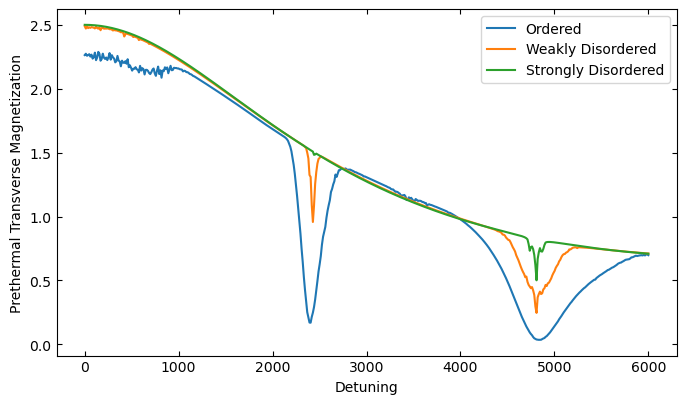

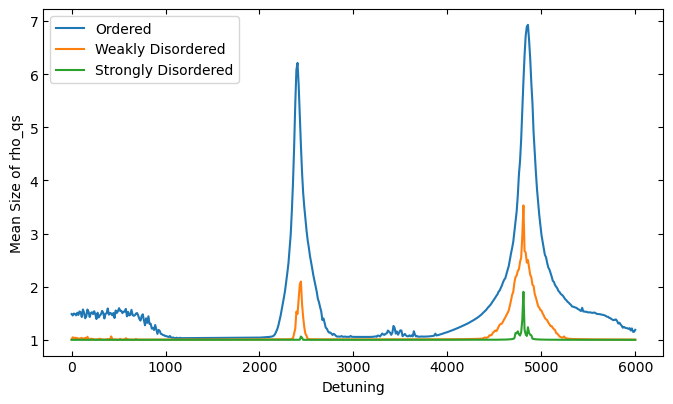

In [13]:
data = np.load("Prethermal_10spinsV2_Ordered.npz")
offset = data["detuning"]
Mqs_ordered = data["M"]
Size_ordered = data["mean_size"]

data = np.load("Prethermal_10spinsV2_WeaklyDisordered.npz")
Mqs_weakdisorder = data["M"]
Size_weakdisorder = data["mean_size"]

data = np.load("Prethermal_10spinsV2_StronglyDisordered.npz")
Mqs_strongdisorder = data["M"]
Size_strongdisorder = data["mean_size"]


fig, ax = plt.subplots(figsize=(8, 4.5))
ax.plot(offset, Mqs_ordered, label='Ordered')
ax.plot(offset, Mqs_weakdisorder, label='Weakly Disordered')
ax.plot(offset, Mqs_strongdisorder, label='Strongly Disordered')
# plt.scatter(offset_exp, Mqs_exp/1400, label='Experiment')
ax.set_xlabel("Detuning")
ax.set_ylabel("Prethermal Transverse Magnetization")
ax.legend()
ax.tick_params(direction='in')
ax.tick_params(top=True, bottom=True, left=True, right=True)
plt.show()

fig, ax = plt.subplots(figsize=(8, 4.5))
ax.plot(offset, Size_ordered, label='Ordered')
ax.plot(offset, Size_weakdisorder, label='Weakly Disordered')
ax.plot(offset, Size_strongdisorder, label='Strongly Disordered')
# plt.scatter(offset_exp, Mqs_exp/1400, label='Experiment')
ax.set_xlabel("Detuning")
ax.set_ylabel("Mean Size of rho_qs")
ax.legend()
ax.tick_params(direction='in')
ax.tick_params(top=True, bottom=True, left=True, right=True)
plt.show()

# fig.savefig("C:\\Users\\Suber\\Desktop\\Size.eps", format='eps', dpi=300)

In [158]:
#Now want to change calculation of d_ij to make it come from an actual calculation of placing 13C on the diamond lattice

mu_0 = 1.256e-6 #NA^-2
hbar = 1.055e-34 #Js
gamma_C = 10.7084e6 #Hz/T

def FCC_lattice(a,size):

    x = a*np.array([1, 0, 0])
    y = a*np.array([0, 1, 0])
    z = a*np.array([0, 0, 1])

    offset = a*np.array([1/4, 1/4, 1/4]) #offset vector for second FCC lattice

    # List of positions in a single unit cell for FCC structure
    fcc_positions = (a/2)*np.array([
        [0, 0, 0],  # Corner atom
        [1, 1, 0],  # Face center (x-y plane)
        [1, 0, 1],  # Face center (x-z plane)
        [0, 1, 1],  # Face center (y-z plane)
        ])

    R = []
    for l in range(-size, size+1):
        for m in range(-size, size+1):
            for n in range(-size, size+1):
                for pos in fcc_positions:
                    R.append(l*x + m*y + n*z + pos)
                    R.append(l*x + m*y + n*z + pos + offset)

    return np.array(R)

def place_specials(size, prob_C):
    R = FCC_lattice(3.57,size)

    specials = random.sample(range(len(R)), int(len(R) * prob_C))
    carbon_indices = random.sample(specials, int(len(R)*prob_C))
    carbon_pts = R[carbon_indices]
    return carbon_pts

def find_cluster(carbon_pts, N):
    if len(carbon_pts) < N:
        raise ValueError("Not enough carbon atoms to form a cluster.")

    seed_idx = random.randint(0, len(carbon_pts) - 1)
    seed = carbon_pts[seed_idx]

    distances = cdist([seed], carbon_pts)[0] 
    nearest_indices = np.argsort(distances)[:N]

    return carbon_pts[nearest_indices]

def azimuthal_angle(p1, p2):
    diff = p1 - p2
    norm_diff = diff/np.linalg.norm(diff)
    return np.arccos(norm_diff[2])

def calculate_W(cluster):

    N = cluster.shape[0]
    W = np.zeros((N, N))
    for i in range(N - 1):
        for j in range(i + 1, N):
            diff = cluster[i] - cluster[j]
            dist = np.linalg.norm(diff)
      
            unit_vec = diff / dist
            angle = np.arccos(unit_vec[2])

            A = 1 - 3 * (np.cos(angle))**2
            B = (np.pi * mu_0 * gamma_C**2 * hbar * A) / (2 * (dist * 1e-10)**3)
            W[i, j] = B
            W[j, i] = B   # symmetry

    return W

44.87543823207336


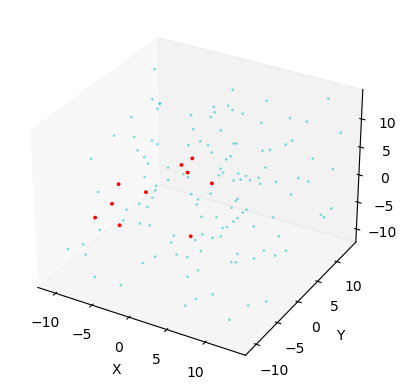

In [178]:
carbon_pts = place_specials(3, 5*1e-2)
cluster = find_cluster(carbon_pts, 10)
W = calculate_W(cluster)
print(np.mean(W))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(carbon_pts[:,0], carbon_pts[:,1], carbon_pts[:,2], color='c', marker='o', alpha = 0.4, s=1)
ax.scatter(cluster[:,0], cluster[:,1], cluster[:,2], color='r', marker='o', alpha = 1, s=3)
ax.grid(False)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

22.078202962875366


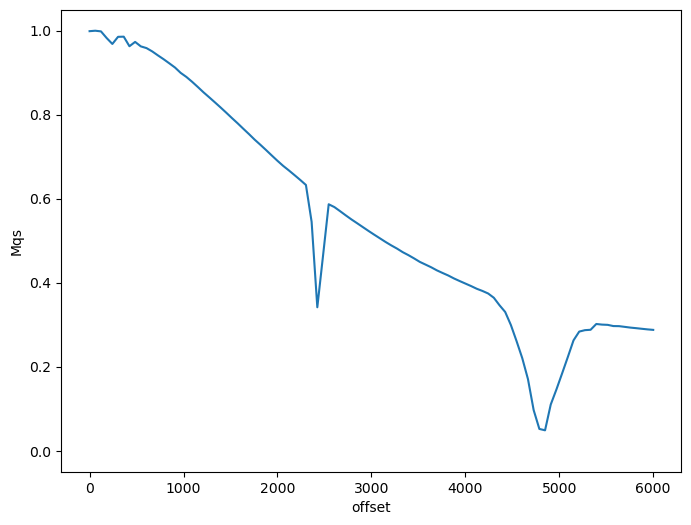

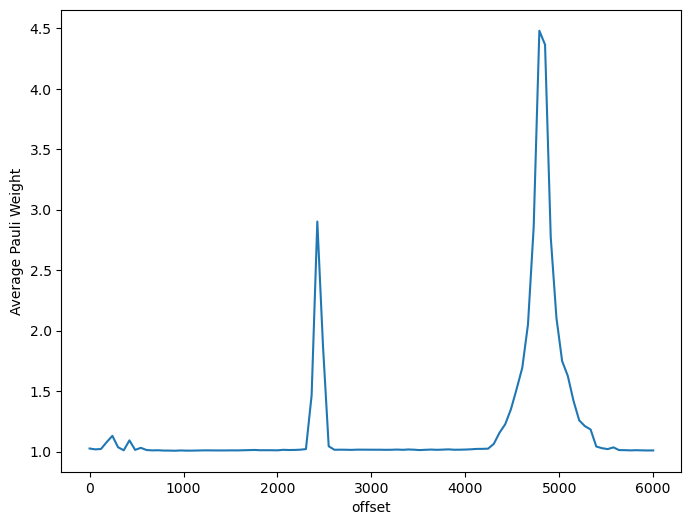

In [161]:
# MASTER CODE

#First randomly place carbons on diamond lattice, find cluster of N carbons, and calculate matrix elements of H_dd.
#Then, using this H_dd, calculate M_qs and mean pauli weight as a function of offset

#Now want to change calculation of d_ij to make it come from an actual calculation of placing 13C on the diamond lattice

import time 

#################### Randomly place 13C on diamond lattice and find cluster ####################
mu_0 = 1.256e-6 #NA^-2
hbar = 1.055e-34 #Js
gamma_C = 10.7084e6 #Hz/T

def FCC_lattice(a,size):

    x = a*np.array([1, 0, 0])
    y = a*np.array([0, 1, 0])
    z = a*np.array([0, 0, 1])

    offset = a*np.array([1/4, 1/4, 1/4]) #offset vector for second FCC lattice

    # List of positions in a single unit cell for FCC structure
    fcc_positions = (a/2)*np.array([
        [0, 0, 0],  # Corner atom
        [1, 1, 0],  # Face center (x-y plane)
        [1, 0, 1],  # Face center (x-z plane)
        [0, 1, 1],  # Face center (y-z plane)
        ])

    R = []
    for l in range(-size, size+1):
        for m in range(-size, size+1):
            for n in range(-size, size+1):
                for pos in fcc_positions:
                    R.append(l*x + m*y + n*z + pos)
                    R.append(l*x + m*y + n*z + pos + offset)

    return np.array(R)

def place_specials(size, prob_C):
    
    R = FCC_lattice(3.57,size)

    specials = random.sample(range(len(R)), int(len(R) * prob_C))
    carbon_indices = random.sample(specials, int(len(R)*prob_C))
    carbon_pts = R[carbon_indices]
    return carbon_pts

def find_cluster(carbon_pts, N):
    if len(carbon_pts) < N:
        raise ValueError("Not enough carbon atoms to form a cluster.")

    seed_idx = random.randint(0, len(carbon_pts) - 1)
    seed = carbon_pts[seed_idx]

    distances = cdist([seed], carbon_pts)[0] 
    nearest_indices = np.argsort(distances)[:N]

    return carbon_pts[nearest_indices]

def azimuthal_angle(p1, p2):
    diff = p1 - p2
    norm_diff = diff/np.linalg.norm(diff)
    return np.arccos(norm_diff[2])

def calculate_W(cluster):

    N = cluster.shape[0]
    W = np.zeros((N, N))
    for i in range(N - 1):
        for j in range(i + 1, N):
            diff = cluster[i] - cluster[j]
            dist = np.linalg.norm(diff)
      
            unit_vec = diff / dist
            angle = np.arccos(unit_vec[2])

            A = 1 - 3 * (np.cos(angle))**2
            B = (np.pi * mu_0 * gamma_C**2 * hbar * A) / (2 * (dist * 1e-10)**3)
            W[i, j] = B
            W[j, i] = B   # symmetry

    return W

######################################## Building Spin Operators ########################################
Sx = (1/2)*np.array([[0, 1], [1, 0]], dtype=complex)
Sy = (1j/2)*np.array([[0, -1], [1, 0]], dtype=complex)
Sz = (1/2)*np.array([[1, 0], [0, -1]], dtype=complex)
Id = np.eye(2, dtype=complex)

def operator_on_spin(op, target, N):
    ops = [Id] * N
    ops[target] = op
    return reduce(np.kron, ops)

def build_spin_operators(N):
    Ix, Iy, Iz = {}, {}, {}
    for n in range(N):
        Ix[n] = operator_on_spin(Sx, n, N)
        Iy[n] = operator_on_spin(Sy, n, N)
        Iz[n] = operator_on_spin(Sz, n, N)
    return Ix, Iy, Iz

def total_spin_operators(N, Ix, Iy, Iz):
    Ix_tot =np.zeros((2**N, 2**N), dtype = complex)
    Iy_tot =np.zeros((2**N, 2**N), dtype = complex)
    Iz_tot =np.zeros((2**N, 2**N), dtype = complex)
    for n in range(N):
        Ix_tot += Ix[n]
        Iy_tot += Iy[n]
        Iz_tot += Iz[n]
    return Ix_tot, Iy_tot, Iz_tot


######################################## Calculate rho_qs ########################################
def calculate_rho_qs(N, size, prob_C, offset, Ix, Iy, Iz, Ix_tot, Iy_tot, Iz_tot):
    
    #Define experiment parameters and Hamiltonians
    w_rabi = 1/(4*56e-6)
    pulselength = 56e-6
    delay = 36e-6
    
    carbon_pts = place_specials(size, prob_C)
    cluster = find_cluster(carbon_pts, N)
    W = calculate_W(cluster)
    
    H_dd = np.zeros((2**N, 2**N), dtype=complex)
    for i in range(N-1):
        for j in range(i+1, N):
            H_ij = -(Ix[i] @ Ix[j]) - (Iy[i] @ Iy[j]) + 2*(Iz[i] @ Iz[j])
            H_dd += W[i,j] * H_ij
            
    H_pulse = 2*np.pi*w_rabi*Ix_tot + 2*np.pi*offset*Iz_tot
    H_delay = 2*np.pi*offset*Iz_tot

    U_pulse = expm(-1j * (H_dd + H_pulse) * pulselength)
    U_delay = expm(-1j * (H_dd + H_delay) * delay)
    U = U_delay @ U_pulse

#     H_eff = (1j / (pulselength + delay)) * logm(U)
    
    rho0 = Ix_tot / 2**N
    
    #Calculate rho_qs
#     eigvals, eigvecs = eig(U)
#     U_dag = inv(eigvecs)

    T, Z = schur(U)  # U = Z T Z†, T is upper-triangular (nearly diagonal)

    rho_rot = Z.conj().T @ rho0 @ Z #rotate into Floquet eigenbasis

    rho_diag = np.diag(np.diag(rho_rot)) #Discard off-diagonals (RWA)

    rho_qs = Z @ rho_diag @ Z.conj().T #Rotate back to quasistationary rho
    
    return rho_qs

######################################## Calculate mean Pauli weight ########################################
pauli_ops = {
    'x': np.array([[0, 1], [1, 0]], dtype=complex), 
    'y': np.array([[0, -1j], [1j, 0]], dtype=complex), 
    'z': np.array([[1, 0], [0, -1]], dtype=complex),
    'i': np.eye(2, dtype=complex)
}

from functools import reduce

def kron_n(ops):
    return reduce(np.kron, ops)

def construct_single_pauli(P, i, N):
    op_list = [pauli_ops['i']] * N
    op_list[i] = pauli_ops[P]
    return kron_n(op_list)

def size_superoperator(rho, N):
    
    S_O = np.zeros_like(rho, dtype=complex)

    for i in range(N):
        for P in ['x', 'y', 'z']:
            P_i = construct_single_pauli(P, i, N)
            S_O += (-1/4) * (P_i @ rho @ P_i.conj().T - rho)
            
    return S_O

def mean_size(rho, N):
    S_O = size_superoperator(rho, N)
    norm = np.trace(rho.conj().T @ rho).real / 2**N
    size = np.trace(rho.conj().T @ S_O).real / 2**N
    return size / norm


######################################## End of definitions ########################################

N = 8 #number of spins
size = 1 #lattice size to sample cluster from
prob_C = 100e-2 #carbon13 concentration

Ix, Iy, Iz = build_spin_operators(N)
Ix_tot, Iy_tot, Iz_tot = total_spin_operators(N, Ix, Iy, Iz)

n_offsets = 100
offset = np.linspace(0, 6e3, n_offsets)
M_qs = np.zeros(n_offsets)
pauli_weight = np.zeros(n_offsets)

start_time = time.time()

for i in range(n_offsets):
    rho_qs = calculate_rho_qs(N, size, prob_C, offset[i], Ix, Iy, Iz, Ix_tot, Iy_tot, Iz_tot)
    M_qs[i] = np.sqrt( (np.trace(rho_qs @ Ix_tot).real)**2 + (np.trace(rho_qs @ Iy_tot).real)**2 )
    pauli_weight[i] = mean_size(rho_qs, N)

end_time = time.time()
print(end_time-start_time)

fig = plt.figure(figsize = (8,6))
plt.plot(offset, M_qs / np.max(M_qs))
plt.ylim(-0.05, 1.05)
plt.xlabel("offset")
plt.ylabel("Mqs")
plt.show()

fig = plt.figure(figsize = (8,6))
plt.plot(offset, pauli_weight)
plt.xlabel("offset")
plt.ylabel("Average Pauli Weight")
plt.show()

(32, 2, 100)
22457.70610308647


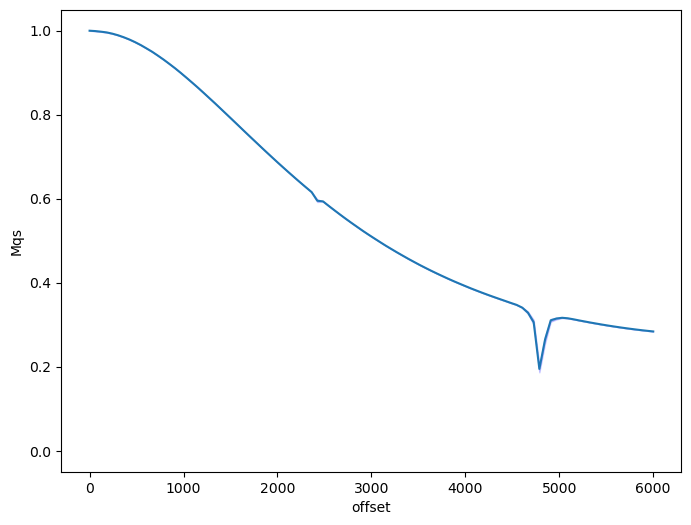

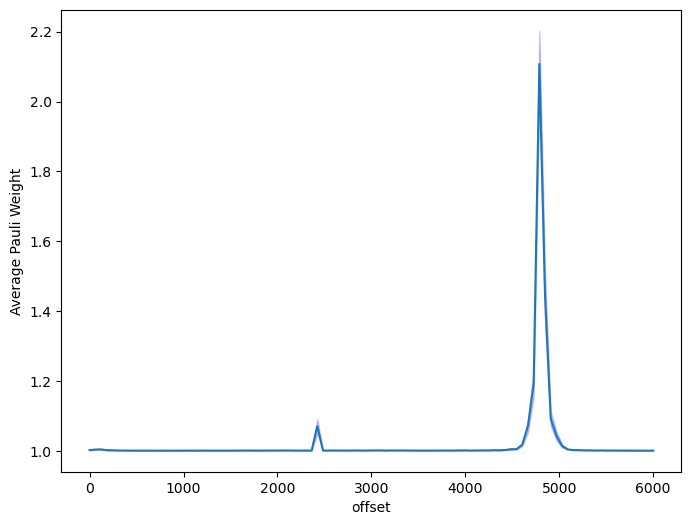

In [170]:
# This will run the above code in parallel with the differnt cpu cores

#First randomly place carbons on diamond lattice, find cluster of N carbons, and calculate matrix elements of H_dd.
#Then, using this H_dd, calculate M_qs and mean pauli weight as a function of offset

#Now want to change calculation of d_ij to make it come from an actual calculation of placing 13C on the diamond lattice

import time 

from pathos.multiprocessing import ProcessingPool as Pool

def run_simulation(dummy):

    import numpy as np
    from functools import reduce
    import random
    from scipy.linalg import expm, schur
    from scipy.spatial.distance import cdist


    #################### Randomly place 13C on diamond lattice and find cluster ####################
    mu_0 = 1.256e-6 #NA^-2
    hbar = 1.055e-34 #Js
    gamma_C = 10.7084e6 #Hz/T

    def FCC_lattice(a,size):

        x = a*np.array([1, 0, 0])
        y = a*np.array([0, 1, 0])
        z = a*np.array([0, 0, 1])

        offset = a*np.array([1/4, 1/4, 1/4]) #offset vector for second FCC lattice

        # List of positions in a single unit cell for FCC structure
        fcc_positions = (a/2)*np.array([
            [0, 0, 0],  # Corner atom
            [1, 1, 0],  # Face center (x-y plane)
            [1, 0, 1],  # Face center (x-z plane)
            [0, 1, 1],  # Face center (y-z plane)
            ])

        R = []
        for l in range(-size, size+1):
            for m in range(-size, size+1):
                for n in range(-size, size+1):
                    for pos in fcc_positions:
                        R.append(l*x + m*y + n*z + pos)
                        R.append(l*x + m*y + n*z + pos + offset)

        return np.array(R)

    def place_specials(size, prob_C):

        R = FCC_lattice(3.57,size)

        specials = random.sample(range(len(R)), int(len(R) * prob_C))
        carbon_indices = random.sample(specials, int(len(R)*prob_C))
        carbon_pts = R[carbon_indices]
        return carbon_pts

    def find_cluster(carbon_pts, N):
        if len(carbon_pts) < N:
            raise ValueError("Not enough carbon atoms to form a cluster.")

        seed_idx = random.randint(0, len(carbon_pts) - 1)
        seed = carbon_pts[seed_idx]

        distances = cdist([seed], carbon_pts)[0] 
        nearest_indices = np.argsort(distances)[:N]

        return carbon_pts[nearest_indices]

    def azimuthal_angle(p1, p2):
        diff = p1 - p2
        norm_diff = diff/np.linalg.norm(diff)
        return np.arccos(norm_diff[2])

    def calculate_W(cluster):

        N = cluster.shape[0]
        W = np.zeros((N, N))
        for i in range(N - 1):
            for j in range(i + 1, N):
                diff = cluster[i] - cluster[j]
                dist = np.linalg.norm(diff)

                unit_vec = diff / dist
                angle = np.arccos(unit_vec[2])

                A = 1 - 3 * (np.cos(angle))**2
                B = (np.pi * mu_0 * gamma_C**2 * hbar * A) / (2 * (dist * 1e-10)**3)
                W[i, j] = B
                W[j, i] = B   # symmetry

        return W

    ######################################## Building Spin Operators ########################################
    Sx = (1/2)*np.array([[0, 1], [1, 0]], dtype=complex)
    Sy = (1j/2)*np.array([[0, -1], [1, 0]], dtype=complex)
    Sz = (1/2)*np.array([[1, 0], [0, -1]], dtype=complex)
    Id = np.eye(2, dtype=complex)

    def operator_on_spin(op, target, N):
        ops = [Id] * N
        ops[target] = op
        return reduce(np.kron, ops)

    def build_spin_operators(N):
        Ix, Iy, Iz = {}, {}, {}
        for n in range(N):
            Ix[n] = operator_on_spin(Sx, n, N)
            Iy[n] = operator_on_spin(Sy, n, N)
            Iz[n] = operator_on_spin(Sz, n, N)
        return Ix, Iy, Iz

    def total_spin_operators(N, Ix, Iy, Iz):
        Ix_tot =np.zeros((2**N, 2**N), dtype = complex)
        Iy_tot =np.zeros((2**N, 2**N), dtype = complex)
        Iz_tot =np.zeros((2**N, 2**N), dtype = complex)
        for n in range(N):
            Ix_tot += Ix[n]
            Iy_tot += Iy[n]
            Iz_tot += Iz[n]
        return Ix_tot, Iy_tot, Iz_tot


    ######################################## Calculate rho_qs ########################################
    def calculate_rho_qs(N, size, prob_C, offset, Ix, Iy, Iz, Ix_tot, Iy_tot, Iz_tot):

        #Define experiment parameters and Hamiltonians
        w_rabi = 1/(4*56e-6)
        pulselength = 56e-6
        delay = 36e-6

        carbon_pts = place_specials(size, prob_C)
        cluster = find_cluster(carbon_pts, N)
        W = calculate_W(cluster)

        H_dd = np.zeros((2**N, 2**N), dtype=complex)
        for i in range(N-1):
            for j in range(i+1, N):
                H_ij = -(Ix[i] @ Ix[j]) - (Iy[i] @ Iy[j]) + 2*(Iz[i] @ Iz[j])
                H_dd += W[i,j] * H_ij

        H_pulse = 2*np.pi*w_rabi*Ix_tot + 2*np.pi*offset*Iz_tot
        H_delay = 2*np.pi*offset*Iz_tot

        U_pulse = expm(-1j * (H_dd + H_pulse) * pulselength)
        U_delay = expm(-1j * (H_dd + H_delay) * delay)
        U = U_delay @ U_pulse

    #     H_eff = (1j / (pulselength + delay)) * logm(U)

        rho0 = Ix_tot / 2**N

        #Calculate rho_qs
    #     eigvals, eigvecs = eig(U)
    #     U_dag = inv(eigvecs)

        T, Z = schur(U)  # U = Z T Z†, T is upper-triangular (nearly diagonal)

        rho_rot = Z.conj().T @ rho0 @ Z #rotate into Floquet eigenbasis

        rho_diag = np.diag(np.diag(rho_rot)) #Discard off-diagonals (RWA)

        rho_qs = Z @ rho_diag @ Z.conj().T #Rotate back to quasistationary rho

        return rho_qs

    ######################################## Calculate mean Pauli weight ########################################
    pauli_ops = {
        'x': np.array([[0, 1], [1, 0]], dtype=complex), 
        'y': np.array([[0, -1j], [1j, 0]], dtype=complex), 
        'z': np.array([[1, 0], [0, -1]], dtype=complex),
        'i': np.eye(2, dtype=complex)
    }

    from functools import reduce

    def kron_n(ops):
        return reduce(np.kron, ops)

    def construct_single_pauli(P, i, N):
        op_list = [pauli_ops['i']] * N
        op_list[i] = pauli_ops[P]
        return kron_n(op_list)

    def size_superoperator(rho, N):

        S_O = np.zeros_like(rho, dtype=complex)

        for i in range(N):
            for P in ['x', 'y', 'z']:
                P_i = construct_single_pauli(P, i, N)
                S_O += (-1/4) * (P_i @ rho @ P_i.conj().T - rho)

        return S_O

    def mean_size(rho, N):
        S_O = size_superoperator(rho, N)
        norm = np.trace(rho.conj().T @ rho).real / 2**N
        size = np.trace(rho.conj().T @ S_O).real / 2**N
        return size / norm


    ######################################## End of definitions ########################################

    N = 10 #number of spins
    size = 6 #lattice size to sample cluster from
    prob_C = 1.1e-2 #carbon13 concentration

    Ix, Iy, Iz = build_spin_operators(N)
    Ix_tot, Iy_tot, Iz_tot = total_spin_operators(N, Ix, Iy, Iz)

    n_offsets = 100
    offset = np.linspace(0, 6e3, n_offsets)
    M_qs = np.zeros(n_offsets)
    pauli_weight = np.zeros(n_offsets)

    for i in range(n_offsets):
        rho_qs = calculate_rho_qs(N, size, prob_C, offset[i], Ix, Iy, Iz, Ix_tot, Iy_tot, Iz_tot)
        M_qs[i] = np.sqrt( (np.trace(rho_qs @ Ix_tot).real)**2 + (np.trace(rho_qs @ Iy_tot).real)**2 )
        pauli_weight[i] = mean_size(rho_qs, N)
        
    return M_qs, pauli_weight


start_time = time.time()

iterations = 32
inputs = [(1)] * iterations

pool = Pool()
# pool.restart()
results = pool.map(run_simulation, inputs)

print(np.array(results).shape)

end_time = time.time()
print(end_time-start_time)

######################################## Plotting ########################################

results = np.array(results)

M_qs_all = results[:, 0, :]
pauli_weight_all = results[:, 1, :]
M_qs_avg = np.mean(M_qs_all, axis=0)
pauli_weight_avg = np.mean(pauli_weight_all, axis=0)

M_qs_error = np.sqrt(np.var(M_qs_all, axis=0) / iterations)
pauli_weight_error = np.sqrt(np.var(pauli_weight_all, axis=0) / iterations)

offset = np.linspace(0, 6e3, 100)

fig = plt.figure(figsize = (8,6))
plt.plot(offset, M_qs_avg / np.max(M_qs_avg))
plt.fill_between(offset, 
                 (M_qs_avg - M_qs_error)/np.max(M_qs_avg), 
                 (M_qs_avg + M_qs_error)/np.max(M_qs_avg), 
                 color='blue', alpha=0.2)
plt.ylim(-0.05, 1.05)
plt.xlabel("offset")
plt.ylabel("Mqs")
plt.show()

fig = plt.figure(figsize = (8,6))
plt.plot(offset, pauli_weight_avg)
plt.fill_between(offset, 
                 pauli_weight_avg - pauli_weight_error, 
                 pauli_weight_avg + pauli_weight_error, 
                 color='blue', alpha=0.2)
plt.xlabel("offset")
plt.ylabel("Average Pauli Weight")
plt.show()

In [171]:
filename = f"PrethermalizationV2_10spins_1.1%.npz"
np.savez(filename, offset = offset, M_qs_all = M_qs_all, pauli_weight_all = pauli_weight_all)

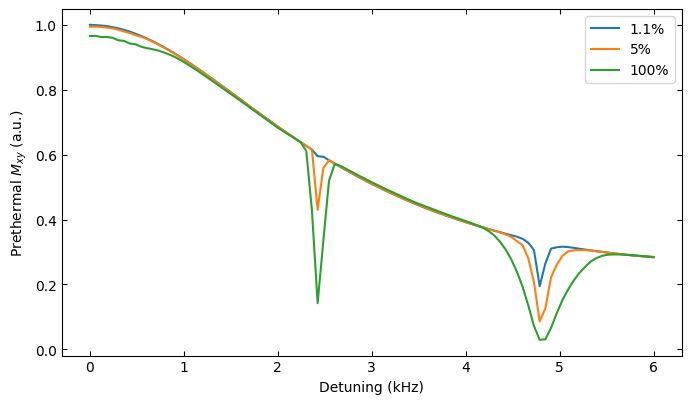

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


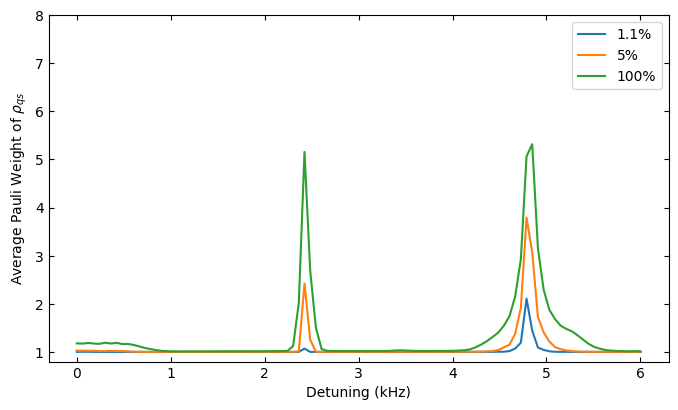

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [18]:
data = np.load("PrethermalizationV2_10spins_1.1%.npz")
offset = data["offset"]
Mqs = data["M_qs_all"]
Mqs_1 = np.mean(Mqs, axis=0)
size = data["pauli_weight_all"]
size_1 = np.mean(size, axis=0)

data = np.load("PrethermalizationV2_10spins_5%.npz")
Mqs = data["M_qs_all"]
Mqs_5 = np.mean(Mqs, axis=0)
size = data["pauli_weight_all"]
size_5 = np.mean(size, axis=0)

data = np.load("PrethermalizationV2_10spins_10%.npz")
Mqs = data["M_qs_all"]
Mqs_10 = np.mean(Mqs, axis=0)
size = data["pauli_weight_all"]
size_10 = np.mean(size, axis=0)

data = np.load("PrethermalizationV2_10spins_100%.npz")
Mqs = data["M_qs_all"]
Mqs_100 = np.mean(Mqs, axis=0)
size = data["pauli_weight_all"]
size_100 = np.mean(size, axis=0)

fig, ax = plt.subplots(figsize=(8, 4.5))
ax.plot(offset/1000, Mqs_1/2.5, label='1.1%')
ax.plot(offset/1000, Mqs_5/2.5, label='5%')
# ax.plot(offset, Mqs_10, label='10%')
ax.plot(offset/1000, Mqs_100/2.5, label='100%')
ax.set_xlabel("Detuning (kHz)")
ax.set_ylabel(r"Prethermal $M_{xy}$ (a.u.)")
ax.legend()
ax.tick_params(direction='in')
ax.tick_params(top=True, bottom=True, left=True, right=True)
plt.show()

# fig.savefig("C:\\Users\\Suber\\Desktop\\PrethermalMxy.eps", format='eps', dpi=300)

fig, ax = plt.subplots(figsize=(8, 4.5))
ax.plot(offset/1000, size_1, label='1.1%')
ax.plot(offset/1000, size_5, label='5%')
# ax.plot(offset, size_10, label='10%')
ax.plot(offset/1000, size_100, label='100%')
ax.set_xlabel("Detuning (kHz)")
ax.set_ylabel(r"Average Pauli Weight of $\rho_{qs}$")
ax.legend()
ax.set_ylim(0.8, 8)
ax.tick_params(direction='in')
ax.tick_params(top=True, bottom=True, left=True, right=True)
plt.show()

# fig.savefig("C:\\Users\\Suber\\Desktop\\PauliWeight.eps", format='eps', dpi=300)